# Real-NVP main script

### Import necessary libraries

In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal

from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_load import *
from utils.plot import *
from nets import make_net
from flows import RealNVP, ReverseBijection, CouplingBijection, Flow, CNF
import time

C:\Users\docuniqam\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\docuniqam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\docuniqam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load data

In [2]:

dataset_name = "two_moons"    
train_loader, test_loader = data_load_split(dataset_name, "./data/" ,  32, 0.8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'



E:\assignment\dt8122-2022\utils\data_load.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  train_df_tensor = torch.tensor(list(train_df.values))


### Create flow using bijections and network

In [3]:
flow = RealNVP(bijections=[
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()),
], net=make_net()).to(device)

flow


RealNVP(
  (bijections): ModuleList(
    (0): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (1): ReverseBijection()
    (2): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (3): ReverseBijection()
    (4): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (5): Reverse

In [4]:
test_data = None
for i,data in enumerate(test_loader):
    if test_data is not None:
        test_data=torch.cat((test_data,data),dim=0)
    else:
        test_data=data.clone()

initial_flow_samples=flow.sample(int(len(test_data)))

In [5]:

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
epochs = 200

print('Training...')
flow = flow.train()
start  = time.time()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_loader):
        x = x.to(device).float()
        optimizer.zero_grad()
        loss = -flow.flow_outputs(x)[1]
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_loader)))

end = time.time()
print('Training finished in: ', (end - start) / 60, 'minutes')
path_model = "./results/realnvp/models/"
if(os.path.exists(path_model)):
    torch.save(flow, f"{path_model}/realnvp-{dataset_name}.pt")
else:
    os.makedirs(path_model)
    torch.save(flow, f"{path_model}/realnvp-{dataset_name}.pt")


Training...
Epoch: 1/200, Loss: 2.411
Epoch: 2/200, Loss: 1.862
Epoch: 3/200, Loss: 1.780
Epoch: 4/200, Loss: 1.702
Epoch: 5/200, Loss: 1.669
Epoch: 6/200, Loss: 1.634
Epoch: 7/200, Loss: 1.626
Epoch: 8/200, Loss: 1.607
Epoch: 9/200, Loss: 1.599
Epoch: 10/200, Loss: 1.585
Epoch: 11/200, Loss: 1.585
Epoch: 12/200, Loss: 1.582
Epoch: 13/200, Loss: 1.572
Epoch: 14/200, Loss: 1.591
Epoch: 15/200, Loss: 1.572
Epoch: 16/200, Loss: 1.601
Epoch: 17/200, Loss: 1.584
Epoch: 18/200, Loss: 1.506
Epoch: 19/200, Loss: 1.459
Epoch: 20/200, Loss: 1.431
Epoch: 21/200, Loss: 1.441
Epoch: 22/200, Loss: 1.450
Epoch: 23/200, Loss: 1.402
Epoch: 24/200, Loss: 1.336
Epoch: 25/200, Loss: 1.326
Epoch: 26/200, Loss: 1.296
Epoch: 27/200, Loss: 1.178
Epoch: 28/200, Loss: 1.128
Epoch: 29/200, Loss: 1.306
Epoch: 30/200, Loss: 1.249
Epoch: 31/200, Loss: 1.189
Epoch: 32/200, Loss: 1.097
Epoch: 33/200, Loss: 0.987
Epoch: 34/200, Loss: 1.022
Epoch: 35/200, Loss: 1.027
Epoch: 36/200, Loss: 1.067
Epoch: 37/200, Loss: 0.98

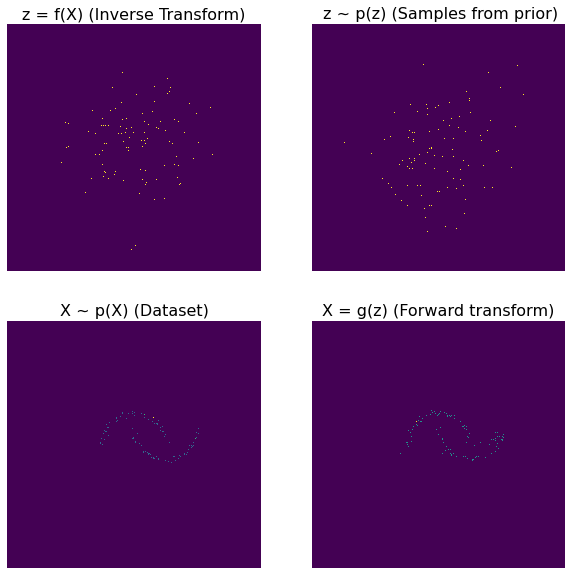

In [6]:
flow = torch.load(f"{path_model}/realnvp-{dataset_name}.pt")
flow = flow.eval()
results_path = "./results/realnvp/"

test =None
for i,data in enumerate(test_loader):
    if test is not None:
        test=torch.cat((test,data),dim=0)
    else:
        test=data.clone()


# #### Forward        
x_dash = flow.sample(len(test_data))

# #### Reverse
z_dash,_ = flow.flow_outputs(test_data.type(torch.float32))

# #### Plotting
plot_samples(test, results_path, dataset_name, initial_flow_samples, x_dash, z_dash, range_min=[-4,4], range_max=[-4,4])
# plot_samples(initial_flow_samples, x_dash, z_dash)

In [7]:
dataset2_name = "two_blobs"    
train_loader2, test_loader2 = data_load_split(dataset2_name, "./data/" ,  32, 0.8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
flow_blobs = RealNVP(bijections=[
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()),
], net=make_net()).to(device)

flow_blobs


RealNVP(
  (bijections): ModuleList(
    (0): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (1): ReverseBijection()
    (2): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (3): ReverseBijection()
    (4): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (5): Reverse

In [9]:
test_data2 = None
for i,data in enumerate(test_loader2):
    if test_data2 is not None:
        test_data2=torch.cat((test_data2, data),dim=0)
    else:
        test_data2=data.clone()

initial_flow_samples_blobs=flow_blobs.sample(int(len(test_data2)))

In [10]:

optimizer = torch.optim.Adam(flow_blobs.parameters(), lr=1e-3)
epochs = 200

print('Training...')
flow_blobs = flow_blobs.train()
start  = time.time()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_loader2):
#         print("xx",x)
        x = x.to(device).float()
        optimizer.zero_grad()
        loss = -flow_blobs.flow_outputs(x)[1]
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_loader2)))

end = time.time()
print('Training finished in: ', (end - start) / 60, 'minutes')
path_model = "./results/realnvp/models/"
if(os.path.exists(path_model)):
    torch.save(flow_blobs, f"{path_model}/realnvp-{dataset2_name}.pt")
else:
    os.makedirs(path_model)
    torch.save(flow_blobs, f"{path_model}/realnvp-{dataset2_name}.pt")


Training...
Epoch: 1/200, Loss: 1.951
Epoch: 2/200, Loss: 1.043
Epoch: 3/200, Loss: 0.842
Epoch: 4/200, Loss: 0.748
Epoch: 5/200, Loss: 0.690
Epoch: 6/200, Loss: 0.688
Epoch: 7/200, Loss: 0.676
Epoch: 8/200, Loss: 0.681
Epoch: 9/200, Loss: 0.640
Epoch: 10/200, Loss: 0.635
Epoch: 11/200, Loss: 0.614
Epoch: 12/200, Loss: 0.612
Epoch: 13/200, Loss: 0.602
Epoch: 14/200, Loss: 0.571
Epoch: 15/200, Loss: 0.568
Epoch: 16/200, Loss: 0.529
Epoch: 17/200, Loss: 0.546
Epoch: 18/200, Loss: 0.541
Epoch: 19/200, Loss: 0.535
Epoch: 20/200, Loss: 0.475
Epoch: 21/200, Loss: 0.468
Epoch: 22/200, Loss: 0.486
Epoch: 23/200, Loss: 0.463
Epoch: 24/200, Loss: 0.452
Epoch: 25/200, Loss: 0.448
Epoch: 26/200, Loss: 0.429
Epoch: 27/200, Loss: 0.437
Epoch: 28/200, Loss: 0.414
Epoch: 29/200, Loss: 0.440
Epoch: 30/200, Loss: 0.403
Epoch: 31/200, Loss: 0.418
Epoch: 32/200, Loss: 0.373
Epoch: 33/200, Loss: 0.384
Epoch: 34/200, Loss: 0.363
Epoch: 35/200, Loss: 0.380
Epoch: 36/200, Loss: 0.386
Epoch: 37/200, Loss: 0.43

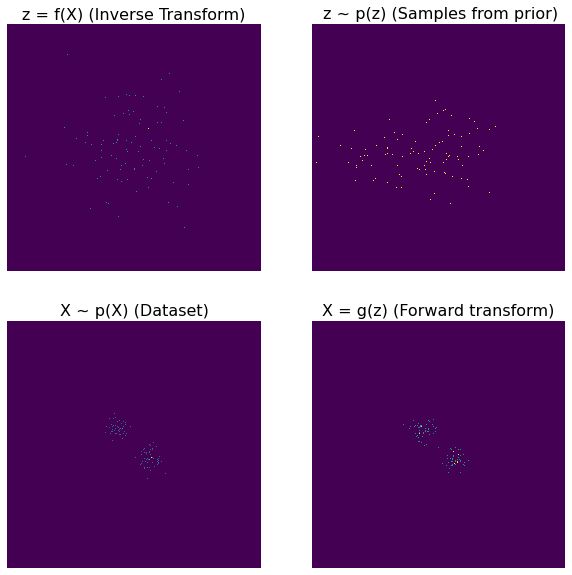

In [11]:
flow_blobs = torch.load(f"{path_model}/realnvp-{dataset2_name}.pt")
flow_blobs = flow_blobs.eval()
results_path = "./results/realnvp/"

test =None
for i,data in enumerate(test_loader2):
    if test is not None:
        test=torch.cat((test,data),dim=0)
    else:
        test=data.clone()


# #### Forward        
x_dash2 = flow_blobs.sample(len(test_data2))

# #### Reverse
z_dash2,_ = flow_blobs.flow_outputs(test_data2.type(torch.float32))

# #### Plotting

plot_samples(test, results_path, dataset2_name, initial_flow_samples_blobs, x_dash2, z_dash2, range_min=[-4,4], range_max=[-4,4])


In [12]:
dataset3_name = "boomerang"    
train_loader3, test_loader3 = data_load_split(dataset3_name, "./data/" ,  32, 0.8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
flow_boomerang = RealNVP(bijections=[
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()), ReverseBijection(),
  CouplingBijection(make_net()),
], net=make_net()).to(device)

flow_boomerang


RealNVP(
  (bijections): ModuleList(
    (0): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (1): ReverseBijection()
    (2): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (3): ReverseBijection()
    (4): CouplingBijection(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): GELU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): GELU()
        (4): Linear(in_features=32, out_features=2, bias=True)
      )
    )
    (5): Reverse

In [14]:
test_data3 = None
for i,data in enumerate(test_loader3):
    if test_data3 is not None:
        test_data3=torch.cat((test_data3, data),dim=0)
    else:
        test_data3=data.clone()

initial_flow_samples_boomerang=flow_boomerang.sample(int(len(test_data3)))

In [17]:

optimizer = torch.optim.Adam(flow_boomerang.parameters(), lr=1e-3)
epochs = 100

print('Training...')
flow_boomerang = flow_boomerang.train()
start  = time.time()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_loader3):
        x = x.to(device).float()
        optimizer.zero_grad()
        loss = -flow_boomerang.flow_outputs(x)[1]
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_loader3)))

end = time.time()
print('Training finished in: ', (end - start) / 60, 'minutes')
path_model = "./results/realnvp/models/"
if(os.path.exists(path_model)):
    torch.save(flow_boomerang, f"{path_model}/realnvp-{dataset3_name}.pt")
else:
    os.makedirs(path_model)
    torch.save(flow_boomerang, f"{path_model}/realnvp-{dataset3_name}.pt")

Training...
Epoch: 1/100, Loss: 4.300
Epoch: 2/100, Loss: 4.246
Epoch: 3/100, Loss: 4.217
Epoch: 4/100, Loss: 4.396
Epoch: 5/100, Loss: 4.391
Epoch: 6/100, Loss: 4.315
Epoch: 7/100, Loss: 4.228
Epoch: 8/100, Loss: 4.247
Epoch: 9/100, Loss: 4.210
Epoch: 10/100, Loss: 4.235
Epoch: 11/100, Loss: 4.230
Epoch: 12/100, Loss: 4.271
Epoch: 13/100, Loss: 4.208
Epoch: 14/100, Loss: 4.332
Epoch: 15/100, Loss: 4.313
Epoch: 16/100, Loss: 4.216
Epoch: 17/100, Loss: 4.229
Epoch: 18/100, Loss: 4.518
Epoch: 19/100, Loss: 4.278
Epoch: 20/100, Loss: 4.276
Epoch: 21/100, Loss: 4.218
Epoch: 22/100, Loss: 4.227
Epoch: 23/100, Loss: 4.241
Epoch: 24/100, Loss: 4.311
Epoch: 25/100, Loss: 4.820
Epoch: 26/100, Loss: 4.383
Epoch: 27/100, Loss: 4.299
Epoch: 28/100, Loss: 4.247
Epoch: 29/100, Loss: 4.301
Epoch: 30/100, Loss: 4.241
Epoch: 31/100, Loss: 4.243
Epoch: 32/100, Loss: 4.273
Epoch: 33/100, Loss: 4.249
Epoch: 34/100, Loss: 4.219
Epoch: 35/100, Loss: 4.200
Epoch: 36/100, Loss: 4.323
Epoch: 37/100, Loss: 4.52

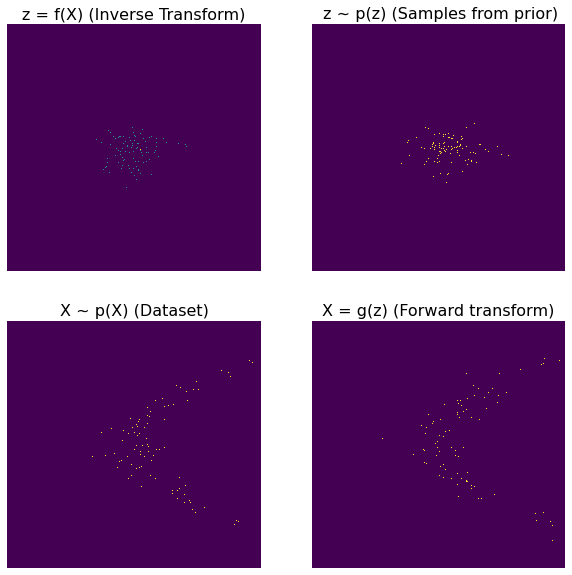

In [18]:
flow_boomerang = torch.load(f"{path_model}/realnvp-{dataset3_name}.pt")
flow_boomerang = flow_boomerang.eval()
results_path = "./results/realnvp/"

test =None
for i,data in enumerate(test_loader3):
    if test is not None:
        test=torch.cat((test,data),dim=0)
    else:
        test=data.clone()


# #### Forward        
x_dash3 = flow_boomerang.sample(len(test_data3))

# #### Reverse
z_dash3,_ = flow_boomerang.flow_outputs(test_data3.type(torch.float32))

# #### Plotting
plot_samples(test, results_path, dataset3_name, initial_flow_samples_boomerang, x_dash3, z_dash3, range_min=[-8,8], range_max=[-8,8])
# plot_samples(initial_flow_samples, x_dash, z_dash)